In [37]:
# DATA
import numpy as np
import sklearn
import sklearn.cluster
import sklearn.model_selection
import pandas as pd
from IPython.display import display
import random
#PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# MISC
import os
import traceback
from datetime import datetime, timedelta
import warnings
import yaml
# UTIL
import util.intracluster_smote as intracluster_smote
import util.evaluation as evaluation
# DATASET UTIL
import util.dataset.mnist_utils as mnist_utils
import util.dataset.asirra_utils as asirra_utils
# AUTOENCODER
import util.autoencoder_keras as autoencoder_keras

In [38]:
# Import Credit Card Dataset
# https://www.kaggle.com/dalpozz/creditcardfraud
cc_scaler = sklearn.preprocessing.MinMaxScaler()
def load_cc(ratio=None):
    cc_data_raw = pd.read_csv('datasets/creditcard.csv')
    cc_data_target = cc_data_raw['Class']
    cc_data = cc_data_raw.drop(['Class'], axis=1)
    cc_data = cc_scaler.fit_transform(cc_data)
    return np.asarray(cc_data), np.asarray(cc_data_target)
X, X_target = load_cc()

In [39]:
experiment_id = '2017-06-07 22h04'

,ROC AUC Score,G-Measure,Balanced F-Measure,F1-Score Macro
Fold,,,,
1,0.872964,0.863897,0.567050,0.783028
2,0.868772,0.867308,0.017302,0.458668
3,0.809169,0.789681,0.127310,0.559892
4,0.714198,0.654596,0.560000,0.779710
5,0.800044,0.775155,0.440299,0.719489


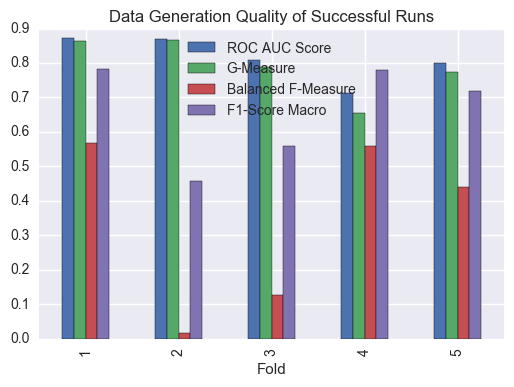

In [40]:
res = pd.read_csv('results/{0}/results_detailed.csv'.format(experiment_id))
res_filtered = res[res['Oversampling'] == 'K-Means on Autoencoder Encoding']
display(res_filtered[['Fold','ROC AUC Score','G-Measure','Balanced F-Measure','F1-Score Macro']].set_index('Fold'))
res_filtered[['Fold','ROC AUC Score','G-Measure','Balanced F-Measure','F1-Score Macro']].set_index('Fold').plot.bar(title='Data Generation Quality of Successful Runs')

In [41]:
ae_by_fold = []
weights_by_fold = []
generated_samples_by_fold = []
for fold in range(1,6):
    weights = np.load('results/{0}/Creditcard Fraud/{1}/ae_weights.npy'.format(experiment_id,fold))
    ae_by_fold.append( autoencoder_keras.Autoencoder.from_weights(weights,X) )
    weights_by_fold.append(weights)
    try: generated_samples = np.load('results/{0}/Creditcard Fraud/{1}/generated_samples_k-means_on_autoencoder_encoding.npy'.format(experiment_id,fold))
    except: generated_samples = np.empty(shape=(0,30))
    generated_samples_by_fold.append(generated_samples)

In [42]:
# Encode the full original dataset to the hidden layer's two dimensions
X_encoded_by_fold = []
for i,ae in enumerate(ae_by_fold):
    X_encoded_by_fold.append( ae.encode(X) )

In [43]:
# Re-encode the generated samples. Although these were generated in the two dimensional space, 
# we only have the final (decoded) version available. 
# This re-encoding is an approximation of where they were really generated.
generated_samples_encoded_by_fold = []
for i,ae in enumerate(ae_by_fold):
    gen_samples_enc = np.asarray(ae.encode(generated_samples_by_fold[i]))
    if gen_samples_enc.size < 1:
        gen_samples_enc = np.empty(shape=(0,2))
    generated_samples_encoded_by_fold.append( gen_samples_enc )

#### Legend

- **Black**: Encoded Majority Instances
- **Red**: Encoded Minority Instances
- **Green**: Re-encoded Generated Minority Samples

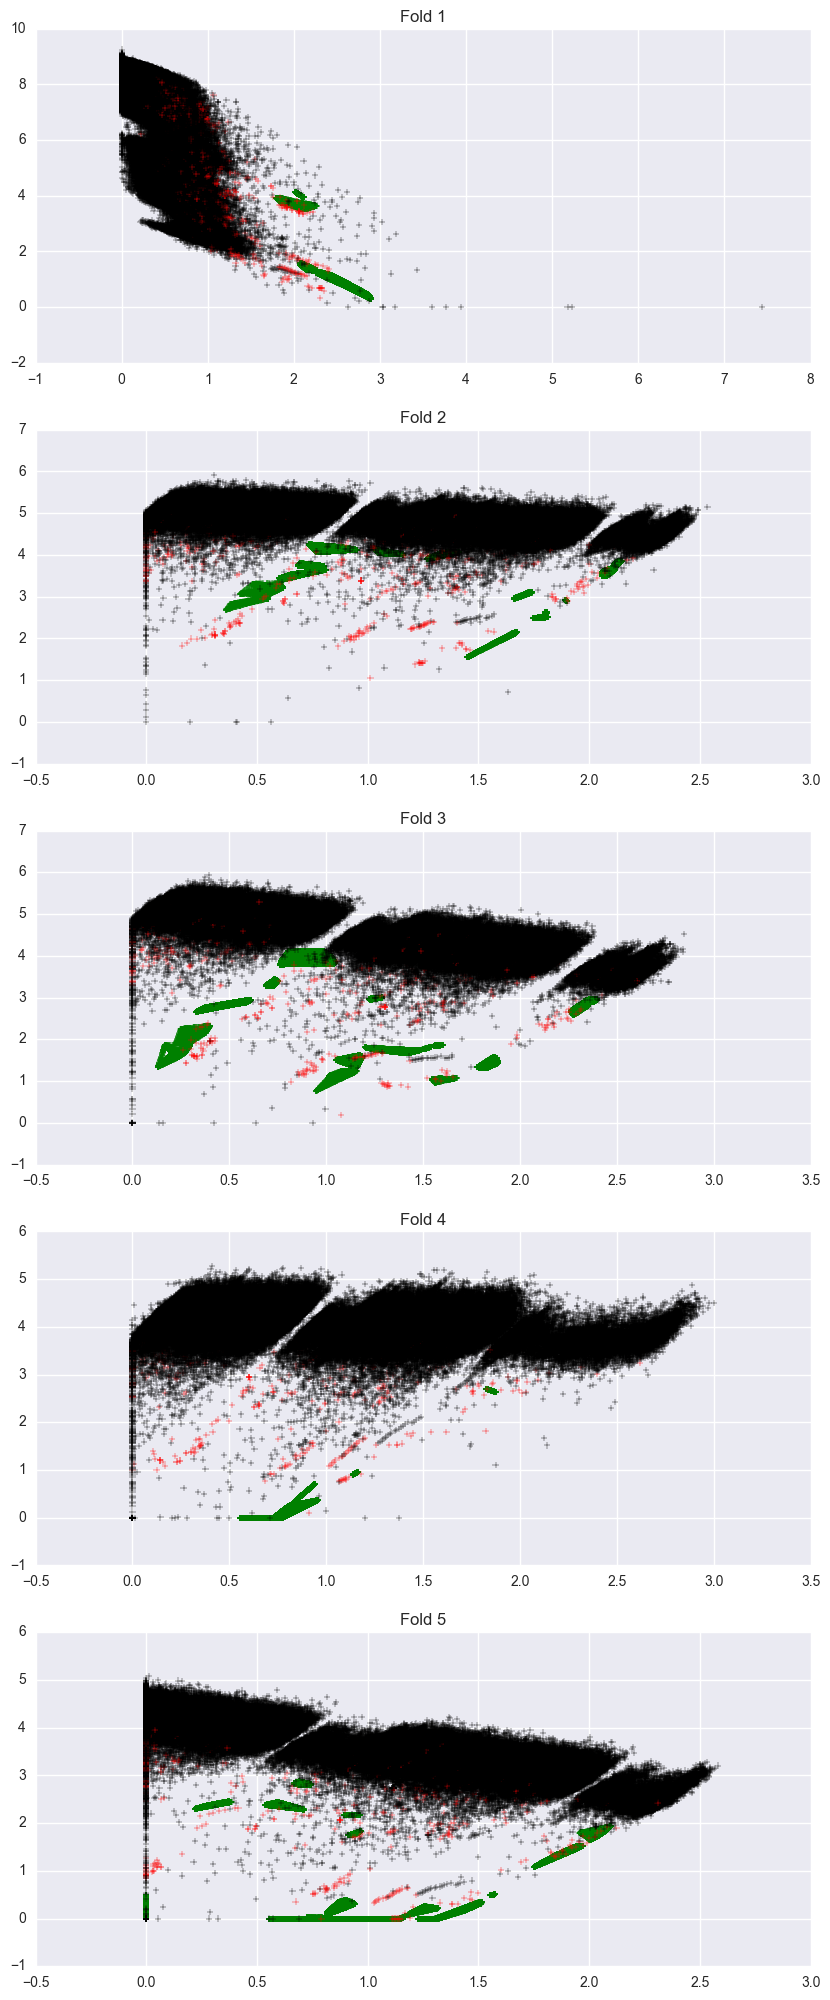

In [44]:
fig,axes = plt.subplots(nrows=len(X_encoded_by_fold), ncols=1, figsize=(10,5*len(X_encoded_by_fold)))
for i, X_encoded in enumerate(X_encoded_by_fold):
    axes[i].scatter(generated_samples_encoded_by_fold[i][:,0],generated_samples_encoded_by_fold[i][:,1], c='green', marker='+')
    axes[i].scatter(X_encoded[:,0],X_encoded[:,1], c=np.asarray(['black','red'])[X_target], marker='+')
    axes[i].set_title('Fold {0}'.format(i+1))

The following output shows weights (without biases) per layer (horizontal) and fold (vertical) just to eyeball zeros.

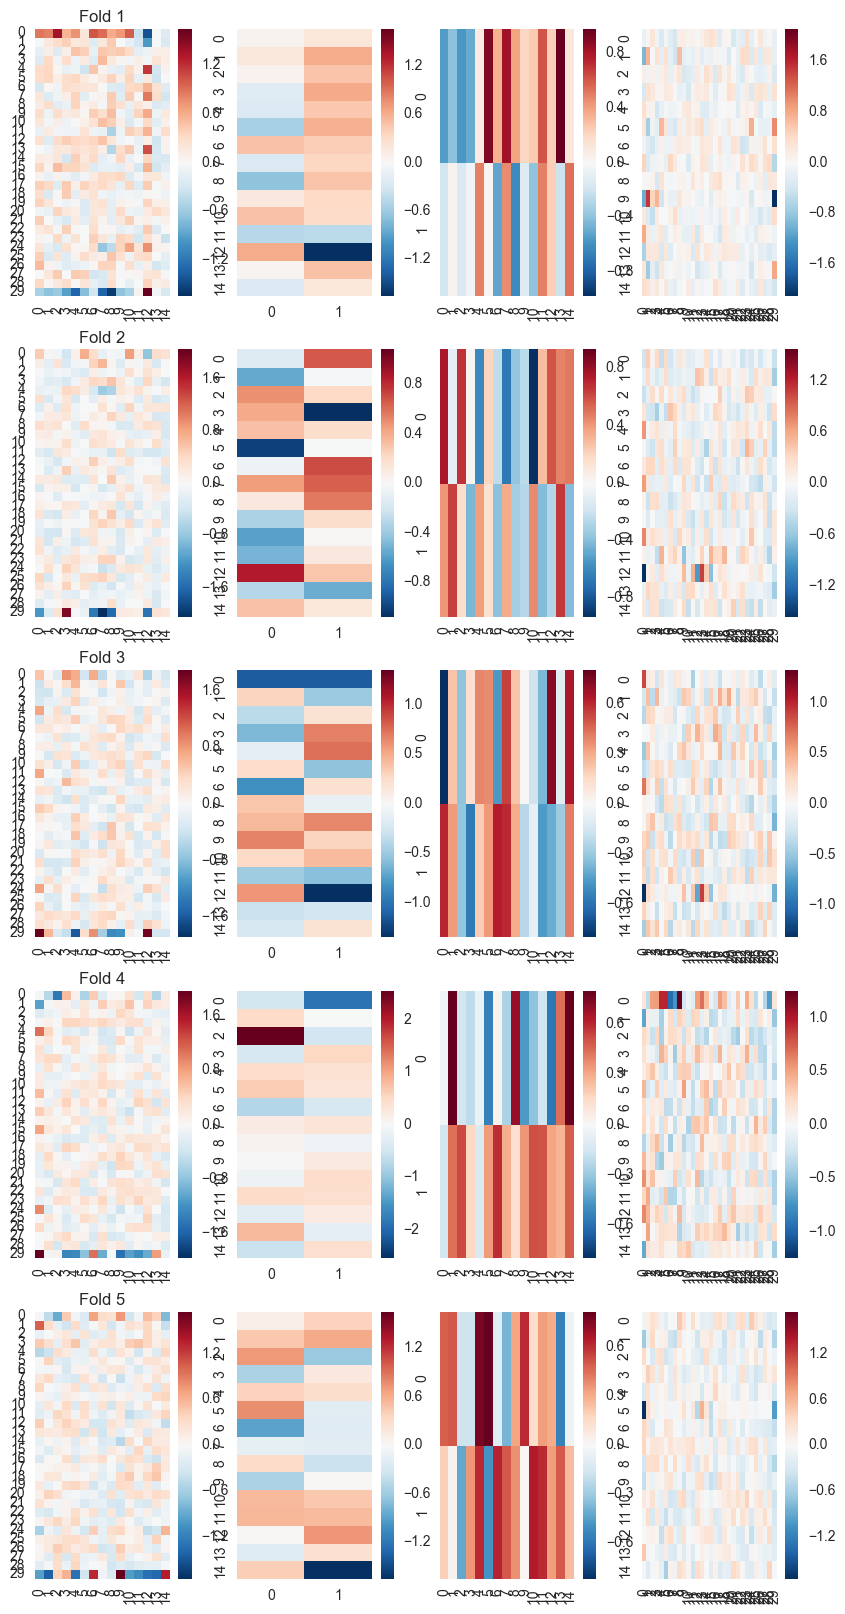

In [45]:
fig,axes = plt.subplots(nrows=len(weights_by_fold), ncols=len(weights_by_fold[0])//2, figsize=(10,5*len(weights_by_fold[0])//2))
for i, weights in enumerate(weights_by_fold):
    for j,w in enumerate(weights[::2]):
        sns.heatmap(w, ax=axes[i][j])
    axes[i][0].set_title('Fold {0}'.format(i+1))